FPS: 34.815, total frames: 2960
Saved MOT loading data to c:\Users\johnn\Johnny's Workspace\Physics\ExpPhys Github\AMO\Data\Dec\loading_JY_2_PHYS348_tk4.csv


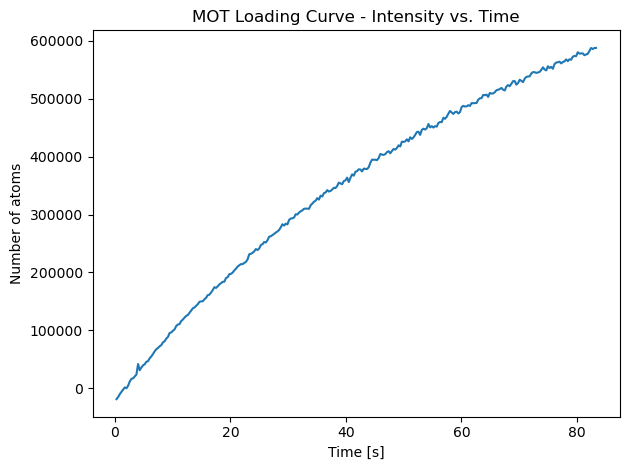

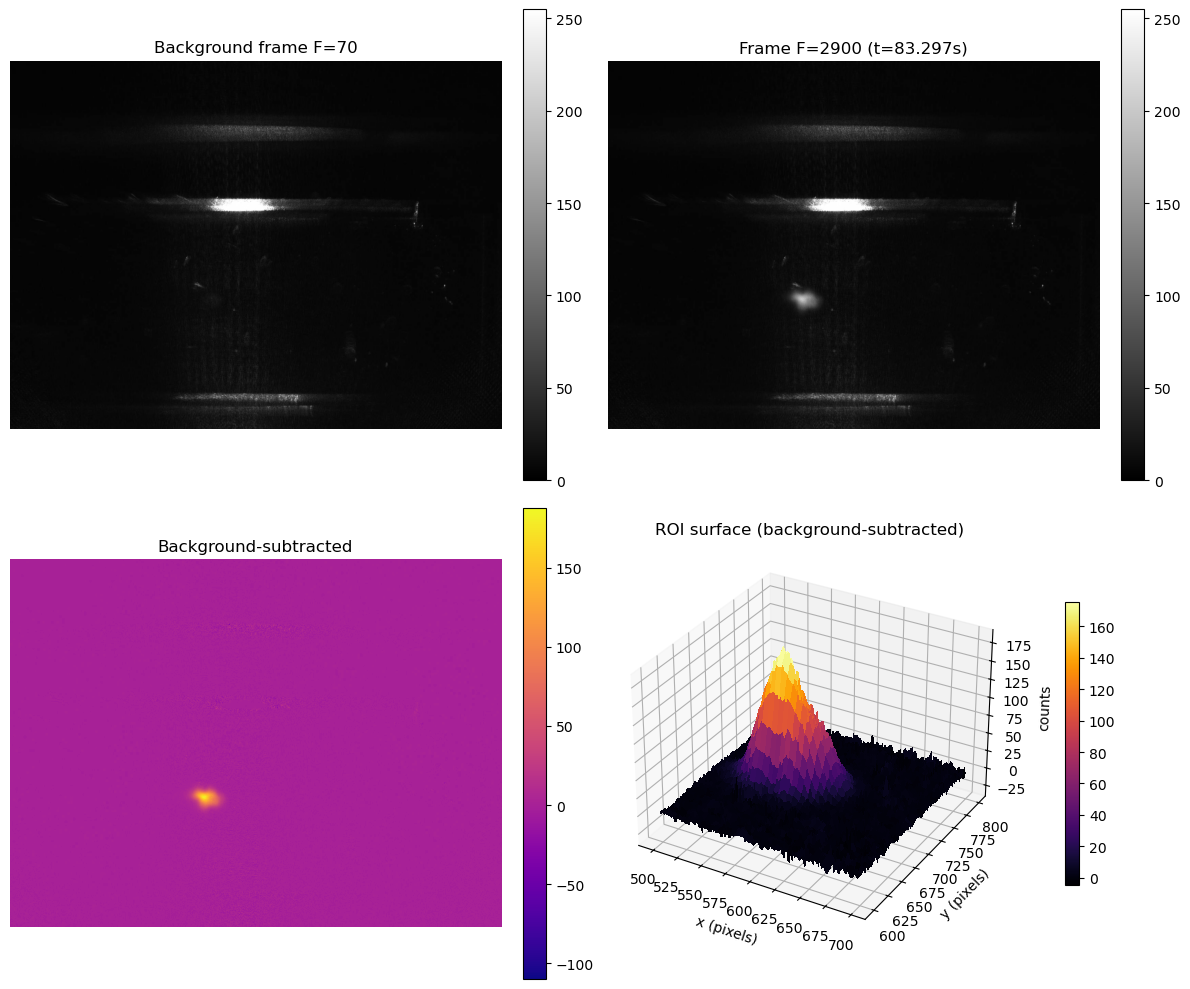

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path


def _resolve_data_dir() -> Path:
    """
    Locate the AMO/Data folder starting from the notebook/script location or CWD.
    """
    base = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
    candidates = [
        base / "Data",
        base.parent / "Data",
        base.parent / "AMO" / "Data",
        base / "AMO" / "Data",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return base / "Data"


data_dir = _resolve_data_dir()
DATA_DIR = data_dir
NOV_DIR = DATA_DIR / "Nov"
DEC_DIR = DATA_DIR / "Dec"


def _plot_preview(bg, pic, good, roi, frame_index, fps, x1, y1, bg_frame_index):
    """Show background, raw frame, background-subtracted frame, and a 3D ROI surface."""
    fig = plt.figure(figsize=(12, 10))

    ax_bg = fig.add_subplot(2, 2, 1)
    im_bg = ax_bg.imshow(bg, cmap="gray")
    ax_bg.set_title(f"Background frame F={bg_frame_index + 1}")
    ax_bg.axis("off")
    fig.colorbar(im_bg, ax=ax_bg, fraction=0.046, pad=0.04)

    ax_total = fig.add_subplot(2, 2, 2)
    im_total = ax_total.imshow(pic, cmap="gray")
    time_label = (frame_index + 1) / fps
    ax_total.set_title(f"Frame F={frame_index + 1} (t={time_label:.3f}s)")
    ax_total.axis("off")
    fig.colorbar(im_total, ax=ax_total, fraction=0.046, pad=0.04)

    ax_sub = fig.add_subplot(2, 2, 3)
    im_sub = ax_sub.imshow(good, cmap="plasma")
    ax_sub.set_title("Background-subtracted")
    ax_sub.axis("off")
    fig.colorbar(im_sub, ax=ax_sub, fraction=0.046, pad=0.04)

    ax_surf = fig.add_subplot(2, 2, 4, projection="3d")
    y_coords = np.arange(y1, y1 + roi.shape[0])
    x_coords = np.arange(x1, x1 + roi.shape[1])
    X, Y = np.meshgrid(x_coords, y_coords)
    surf = ax_surf.plot_surface(X, Y, roi, cmap=cm.inferno, linewidth=0, antialiased=False)
    ax_surf.set_title("ROI surface (background-subtracted)")
    ax_surf.set_xlabel("x (pixels)")
    ax_surf.set_ylabel("y (pixels)")
    ax_surf.set_zlabel("counts")
    fig.colorbar(surf, ax=ax_surf, shrink=0.6, pad=0.1)

    fig.tight_layout()


def image_analysis_x(
    root=None,
    filename="MOT_loading_121025_take4.avi",
    out_prefix="loading_JY_2_PHYS348_tk4",
    frame_step=10,
    max_iterations=290,
    preview_frame=None,
    roi_bounds=(499, 700, 599, 800),
):
    """
    Python port of image_analysis_x.m with preview plots.

    Parameters
    ----------
    root : str or Path, optional
        Directory containing the AVI file. Defaults to AMO/Data/Dec (falls back
        to AMO/Data/Nov) so the MOT videos can stay in their month folders.
    filename : str
        Name of the video file.
    out_prefix : str
        Prefix for the output CSV file.
    frame_step : int
        Step between sampled frames (MATLAB used F=i*10).
    max_iterations : int
        Maximum number of frame samples (MATLAB used 290).
    preview_frame : int or None
        1-based frame number to preview. Defaults to the last processed frame.
    roi_bounds : tuple[int, int, int, int]
        (x1, x2, y1, y2) bounds in pixel indices (0-based start, exclusive end).
        Defaults match MATLAB's ROI (500:700, 600:800) converted to Python indexing.
    """
    if root is None:
        if DEC_DIR.exists():
            root = DEC_DIR
        elif NOV_DIR.exists():
            root = NOV_DIR
        else:
            raise FileNotFoundError(
                "Neither AMO/Data/Dec nor AMO/Data/Nov is available; set root manually."
            )

    root = Path(root)
    if not root.exists():
        raise FileNotFoundError(f"Video directory does not exist: {root}")
    video_path = root / filename

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video file: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 34.815
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"FPS: {fps:.3f}, total frames: {frame_count}")

    F_bg = 70
    bg_frame_index = F_bg - 1
    if bg_frame_index >= frame_count:
        raise ValueError(
            f"Background frame {F_bg} exceeds available frames ({frame_count})."
        )

    def get_frame(frame_index: int) -> np.ndarray:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ok, frame = cap.read()
        if not ok:
            raise ValueError(f"Could not read frame {frame_index}")
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return gray.astype(np.float64)

    bg = get_frame(bg_frame_index)

    lambda_rb = 780.241368271e-9  # [m]
    Gamma = 2 * np.pi * 6.066e6   # [Hz]
    tau = 26.2348e-9              # [s]

    IIsat = 0.490 / 1.671         # I / Isat, dimensionless

    radius = 1.0                  # lens radius [in]
    dist = 19.625                 # distance MOT-lens [in]

    te = 20.392e-3                # exposure time [s]
    qbar = 2.967                  # counts per photon-ish factor

    det_rat = 3.0                 # detuning ratio (Delta/Gamma)
    rho_ee = 0.5 * IIsat / (4 * det_rat**2 + IIsat + 1)  # excited-state fraction

    omega = np.pi * (radius / dist) ** 2
    eta = omega / (4 * np.pi)     # collection efficiency

    x1_raw, x2_raw, y1_raw, y2_raw = roi_bounds
    height, width = bg.shape
    x1 = max(0, min(x1_raw, width - 1))
    x2 = max(x1 + 1, min(x2_raw, width))
    y1 = max(0, min(y1_raw, height - 1))
    y2 = max(y1 + 1, min(y2_raw, height))

    times = []
    numbers = []
    preview_data = None
    last_frame_data = None
    preview_target = preview_frame - 1 if preview_frame is not None else None

    for i in range(1, max_iterations + 1):
        F = i * frame_step
        frame_index = F - 1
        if frame_index >= frame_count:
            print(f"Stopping early at frame {frame_index + 1}; video has {frame_count} frames.")
            break

        try:
            pic = get_frame(frame_index)
        except ValueError:
            print(f"Stopping early: could not read frame {frame_index + 1}")
            break

        good = pic - bg
        roi = good[y1:y2, x1:x2]

        if roi.size == 0:
            raise ValueError("ROI is empty; adjust roi_bounds to fit inside the frame.")

        Nc = roi.sum()
        Na = Nc * qbar / ((eta * te / tau) * rho_ee)
        Ta = F / fps

        times.append(Ta)
        numbers.append(Na)

        frame_package = {
            "frame_index": frame_index,
            "pic": pic,
            "good": good,
            "roi": roi,
        }
        last_frame_data = frame_package

        if preview_target is None:
            preview_data = frame_package
        elif frame_index == preview_target:
            preview_data = frame_package

    cap.release()

    times = np.array(times)
    numbers = np.array(numbers)

    out_csv = root / f"{out_prefix}.csv"
    df = pd.DataFrame({"time_s": times, "N_atoms": numbers})
    df.to_csv(out_csv, index=False)
    print(f"Saved MOT loading data to {out_csv}")

    plt.figure()
    plt.plot(times, numbers)
    plt.xlabel("Time [s]")
    plt.ylabel("Number of atoms")
    plt.title("MOT Loading Curve - Intensity vs. Time")
    plt.tight_layout()

    if preview_data is None:
        preview_data = last_frame_data

    if preview_data:
        _plot_preview(
            bg=bg,
            pic=preview_data["pic"],
            good=preview_data["good"],
            roi=preview_data["roi"],
            frame_index=preview_data["frame_index"],
            fps=fps,
            x1=x1,
            y1=y1,
            bg_frame_index=bg_frame_index,
        )

    plt.show()


if __name__ == "__main__":
    # December data lives in AMO/Data/Dec; November in AMO/Data/Nov
    image_analysis_x()
    # Example for November data:
    # image_analysis_x(NOV_DIR, filename="JY_MOT2.avi", out_prefix="loading_JY_Nov")
